<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/correlation/folder/nifty_usd_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import  datetime


In [6]:
data=pd.read_csv('/content/NSE_NIFTY1!, 1D.csv')

In [7]:
data.head(2)

,time,open,high,low,close,"USDINR, IDC: Open","USDINR, IDC: High","USDINR, IDC: Low","USDINR, IDC: Close",Volume,Volume MA
0,1193370300,5478.0,5706.10,5478.0,5684.00,39.35,39.890,39.27,39.30,32100,NaN
1,1193629500,5800.0,5914.45,5800.0,5907.15,39.30,39.885,39.24,39.33,29700,NaN


In [8]:
data['date']=data.time.apply(lambda d: datetime.datetime.fromtimestamp(int(d)).strftime('%d-%m-%Y'))

In [9]:
del data['time']

In [10]:
data= data.set_index('date')

In [11]:
data.head(2)

,open,high,low,close,"USDINR, IDC: Open","USDINR, IDC: High","USDINR, IDC: Low","USDINR, IDC: Close",Volume,Volume MA
date,,,,,,,,,,
26-10-2007,5478.0,5706.10,5478.0,5684.00,39.35,39.890,39.27,39.30,32100,NaN
29-10-2007,5800.0,5914.45,5800.0,5907.15,39.30,39.885,39.24,39.33,29700,NaN


In [12]:
data_subset=data[['close','USDINR, IDC: Close']]

In [13]:
data_subset.tail()

,close,"USDINR, IDC: Close"
date,,
05-01-2022,17960.95,74.270
06-01-2022,17788.65,74.380
07-01-2022,17854.30,74.271
10-01-2022,18048.20,74.020
11-01-2022,18083.55,73.781


In [15]:
data_subset.columns=['close','close1']

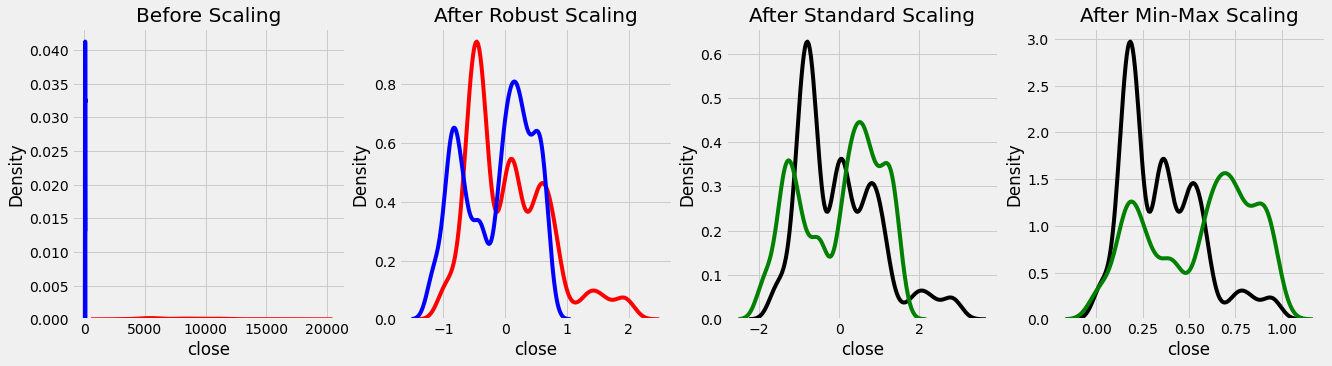

In [16]:
# Importing libraries
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
% matplotlib inline
matplotlib.style.use('fivethirtyeight')

# data
x = data_subset
scaler = preprocessing.RobustScaler()
robust_df = scaler.fit_transform(x)
robust_df = pd.DataFrame(robust_df, columns =['close','close1'])

scaler = preprocessing.StandardScaler()
standard_df = scaler.fit_transform(x)
standard_df = pd.DataFrame(standard_df, columns =['close','close1'])

scaler = preprocessing.MinMaxScaler()
minmax_df = scaler.fit_transform(x)
minmax_df = pd.DataFrame(minmax_df, columns =['close','close1'])

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))
ax1.set_title('Before Scaling')

sns.kdeplot(x['close'], ax = ax1, color ='r')
sns.kdeplot(x['close1'], ax = ax1, color ='b')
ax2.set_title('After Robust Scaling')

sns.kdeplot(robust_df['close'], ax = ax2, color ='red')
sns.kdeplot(robust_df['close1'], ax = ax2, color ='blue')
ax3.set_title('After Standard Scaling')

sns.kdeplot(standard_df['close'], ax = ax3, color ='black')
sns.kdeplot(standard_df['close1'], ax = ax3, color ='g')
ax4.set_title('After Min-Max Scaling')

sns.kdeplot(minmax_df['close'], ax = ax4, color ='black')
sns.kdeplot(minmax_df['close1'], ax = ax4, color ='g')
plt.show()


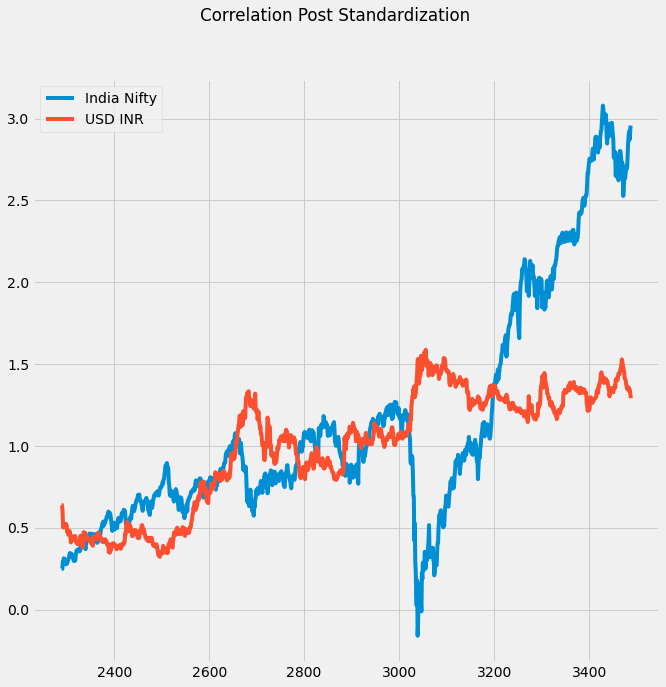

In [17]:
columns=['India Nifty','USD INR']
standard_df=standard_df.fillna(method='ffill')
standard_df.columns=columns
standard_df[-1200:].plot(figsize=(10,10))
plt.suptitle('Correlation Post Standardization')
plt.show()

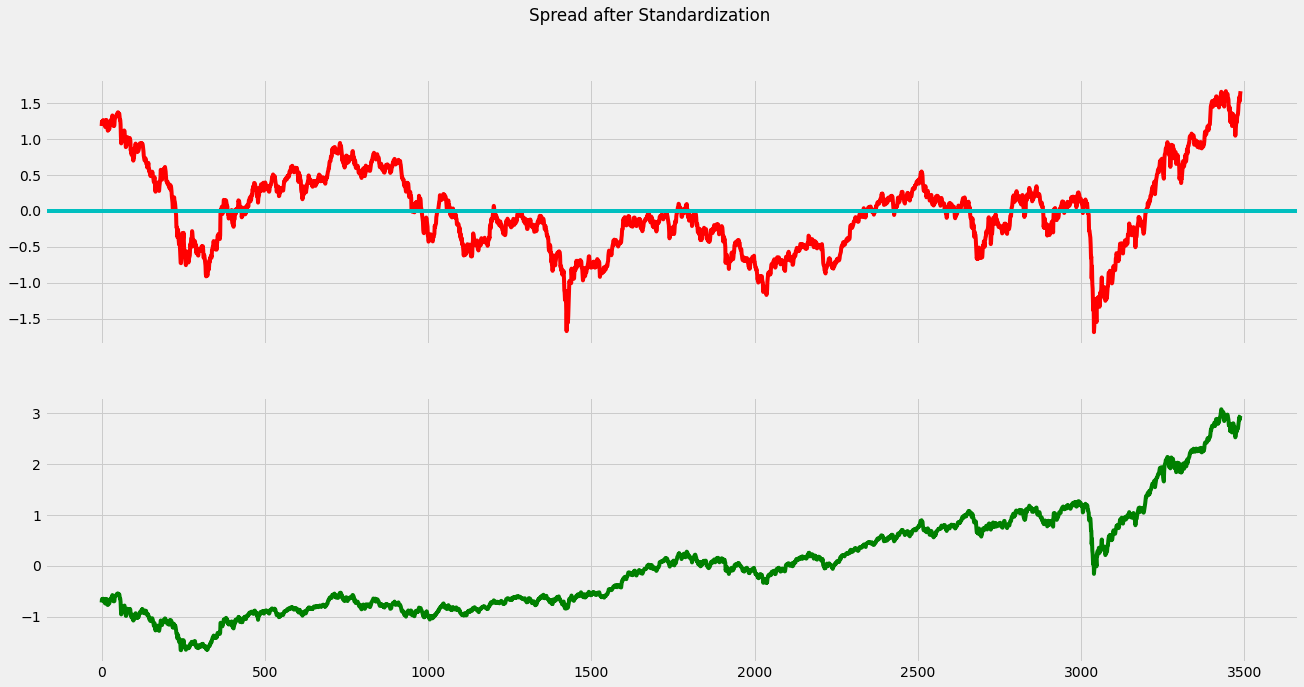

In [20]:
standard_df['diff']=standard_df['India Nifty']-standard_df['USD INR']

plt.rcParams["figure.figsize"] = (20,10)
fig,ax=plt.subplots(2,1,sharex=True)
ax[0].plot(standard_df['diff'],color='r')
ax[1].plot(standard_df['India Nifty'],color='g')
ax[0].axhline(y=0,color='c')
#ax[0].axhline(y=-3,color='g')
plt.suptitle('Spread after Standardization')

plt.show()